In [1]:
import tensorflow as tf
import torch

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("CUDA Available: ", torch.cuda.is_available())
print("CUDA Device Count: ", torch.cuda.device_count())

Num GPUs Available:  1
CUDA Available:  True
CUDA Device Count:  1


**json 파일 불러오기**
- 국립국어원 개체명 분석 말뭉치 2022 데이터셋

In [2]:
import json

file_path = ["../dataset/NLNE2202211219.json",  # 신문
             "../dataset/SDNE2202211219.json",  # 일상 대화
             "../dataset/MDNE2202211219.json"   # 온라인 대화
             ]
             
json_data = []

for path in file_path:
    with open(path, "r", encoding='utf-8') as f:
        json_data.append(json.load(f))

**BIO 태깅**

In [92]:
bio = []

def json_to_df(data):
    for doc in data['document'][:int(len(data['document'])*0.1)]:   # 데이터가 너무 많아서 30%씩 사용
        for sentence in doc['sentence']:
            tokens = [word['form'] for word in sentence['word']]
            labels = ['O'] * len(tokens)
            index = [i for i in range(1, len(tokens)+1)]

            for ne in sentence['NE']:
                ne_start = ne['begin']
                ne_end = ne['end']
                ne_label = ne['label']

                for idx, word in enumerate(sentence['word']):
                    word_start = word['begin']
                    word_end = word['end']
                    if word_start >= ne_start and  word_end <= ne_end:
                        if word['begin'] == ne_start:
                            labels[idx] = 'B-' + ne_label
                        else:
                            labels[idx] = 'I-' + ne_label

            bio.append((index, tokens, labels))

for i in range(3):
    json_to_df(json_data[i])

In [93]:
for index, tokens, labels in bio[:2]:
    for index, token, label in zip(index, tokens, labels):
        print(f"{index}  {token}\t{label}")
    print()

print(bio[0])

1  태안군의회,	O
2  2019년‘군민중심’의정성과	O
3  빛났다!	O

1  태안군의회	B-OGG_POLITICS
2  김기두	B-PS_NAME
3  의장이	O
4  지난해	B-DT_YEAR
5  거둔	O
6  성과를	O
7  바탕으로	O
8  올	B-DT_DURATION
9  한해	I-DT_DURATION
10  군민	O
11  중심의	O
12  의정활동을	O
13  펼치겠다는	O
14  힘찬	O
15  포부를	O
16  밝혔다.	O

([1, 2, 3], ['태안군의회,', '2019년‘군민중심’의정성과', '빛났다!'], ['O', 'O', 'O'])


**데이터 프레임으로 변환**

In [94]:
import pandas as pd

df = pd.DataFrame(columns=['index', 'word', 'tag'])

index = []  # 문장 내 순서, 1이 나올 때마다 새로운 문장
word = []
tag = []

for i, w, t in bio:
    index.extend(i)
    word.extend(w)
    tag.extend(t)

df['index'] = index
df['word'] = word
df['tag'] = tag

df

,index,word,tag
0,1,"태안군의회,",O
1,2,2019년‘군민중심’의정성과,O
2,3,빛났다!,O
3,1,태안군의회,B-OGG_POLITICS
4,2,김기두,B-PS_NAME
...,...,...,...
528377,2,게임중독자다,O
528378,1,게임이,O
528379,2,뭐,O
528380,3,그렇게,O


In [95]:
df['tag'].unique()

array(['O', 'B-OGG_POLITICS', 'B-PS_NAME', 'B-DT_YEAR', 'B-DT_DURATION',
       'I-DT_DURATION', 'B-DT_DAY', 'I-DT_DAY', 'B-AF_BUILDING',
       'B-QT_COUNT', 'I-OGG_POLITICS', 'B-CV_POSITION', 'B-DT_MONTH',
       'B-LCP_COUNTRY', 'B-LCP_CITY', 'B-OGG_EDUCATION', 'I-DT_YEAR',
       'B-QT_PRICE', 'I-QT_PRICE', 'B-EV_FESTIVAL', 'B-CV_POLICY',
       'B-PT_GRASS', 'I-TMI_PROJECT', 'I-AF_BUILDING', 'B-AF_ROAD',
       'B-LC_OTHERS', 'B-TMI_PROJECT', 'I-QT_COUNT', 'B-DT_OTHERS',
       'I-DT_OTHERS', 'I-LC_OTHERS', 'B-QT_MAN_COUNT', 'B-OGG_LAW',
       'B-TM_DIRECTION', 'B-LCP_COUNTY', 'I-DT_MONTH', 'B-OGG_OTHERS',
       'I-OGG_OTHERS', 'B-LCP_PROVINCE', 'B-TMI_HW', 'B-QT_PERCENTAGE',
       'B-QT_AGE', 'B-OGG_SCIENCE', 'B-MT_CHEMICAL', 'B-OGG_ECONOMY',
       'B-AF_MUSICAL_INSTRUMENT', 'B-AFW_OTHER_PRODUCTS',
       'I-AFW_OTHER_PRODUCTS', 'B-TM_COLOR', 'B-QT_LENGTH',
       'B-CV_OCCUPATION', 'B-LCP_CAPITALCITY', 'B-CV_CULTURE',
       'I-CV_CULTURE', 'B-CV_LAW', 'I-QT_MAN_COUNT', 'B-L

**tag 값 일반화**
- 세분류로 나눠진 값을 대분류로 변환

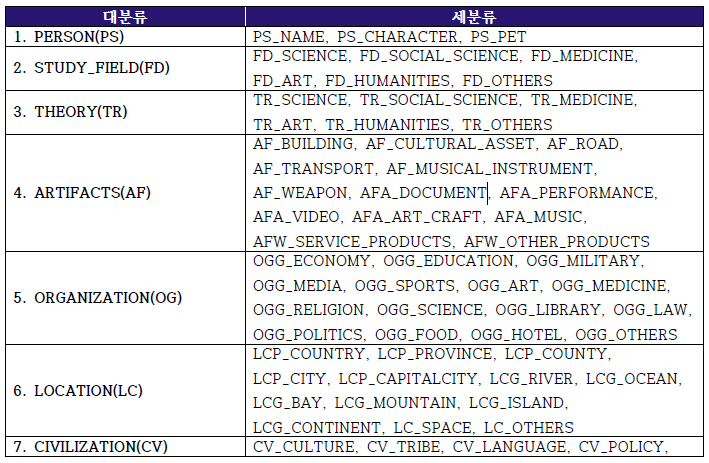

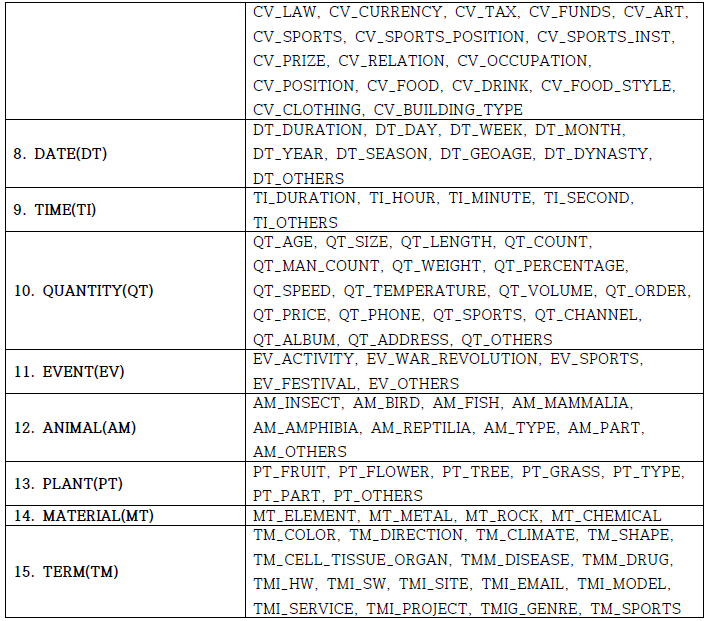

In [96]:
# _ 기준으로 앞의 값만 사용
df['tag'] = df['tag'].apply(lambda x : x.split("_")[0])
df.head()

,index,word,tag
0,1,"태안군의회,",O
1,2,2019년‘군민중심’의정성과,O
2,3,빛났다!,O
3,1,태안군의회,B-OGG
4,2,김기두,B-PS


In [97]:
df['tag'].unique()

array(['O', 'B-OGG', 'B-PS', 'B-DT', 'I-DT', 'B-AF', 'B-QT', 'I-OGG',
       'B-CV', 'B-LCP', 'I-QT', 'B-EV', 'B-PT', 'I-TMI', 'I-AF', 'B-LC',
       'B-TMI', 'I-LC', 'B-TM', 'B-MT', 'B-AFW', 'I-AFW', 'I-CV', 'B-LCG',
       'B-TI', 'I-LCG', 'I-EV', 'I-TI', 'B-TR', 'I-TR', 'B-TMM', 'B-AM',
       'I-PS', 'B-AFA', 'B-FD', 'I-AFA', 'I-AM', 'I-TM', 'I-LCP', 'I-TMM',
       'I-MT', 'I-FD', 'B-TMIG', 'I-TMIG'], dtype=object)

In [98]:
df['tag'] = df['tag'].str.replace("AFA", "AF")
df['tag'] = df['tag'].str.replace("AFW", "AF")
df['tag'] = df['tag'].str.replace("LCP", "LC")
df['tag'] = df['tag'].str.replace("LCG", "LC")
df['tag'] = df['tag'].str.replace("TMM", "TM")
df['tag'] = df['tag'].str.replace("TMI", "TM")
df['tag'] = df['tag'].str.replace("TMG", "TM")
df['tag'] = df['tag'].str.replace("TMIG", "TM")

In [99]:
df['tag'].unique()

array(['O', 'B-OGG', 'B-PS', 'B-DT', 'I-DT', 'B-AF', 'B-QT', 'I-OGG',
       'B-CV', 'B-LC', 'I-QT', 'B-EV', 'B-PT', 'I-TM', 'I-AF', 'B-TM',
       'I-LC', 'B-MT', 'I-CV', 'B-TI', 'I-EV', 'I-TI', 'B-TR', 'I-TR',
       'B-AM', 'I-PS', 'B-FD', 'I-AM', 'I-MT', 'I-FD'], dtype=object)

**개체 분포**

<Axes: xlabel='tag'>

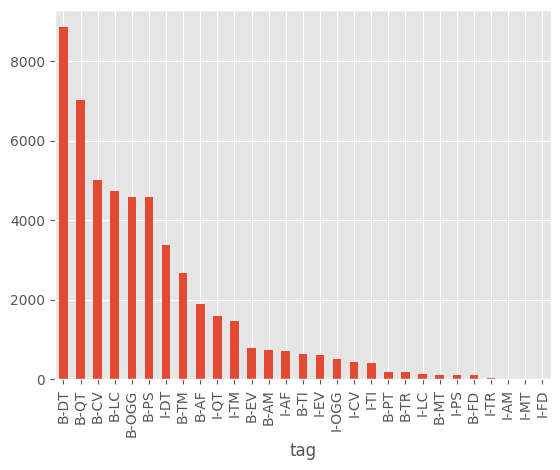

In [100]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df['tag'].value_counts()[1:].plot(kind='bar')   # O는 너무 많아서 빼고 보자

In [101]:
df.isna().sum()

index    0
word     0
tag      0
dtype: int64

**하나의 문장에 등장한 단어와 개체명끼리 묶기**

In [102]:
sentences_tags = []
current_sentences = []

for i, row in df.iterrows():
    word = row['word']
    tag = row['tag']

    if row['index'] == 1 and i != 0:    # 새로운 문장 처리
        sentences_tags.append(current_sentences)
        current_sentences = []

    current_sentences.append((word, tag))

# 마지막 문장 처리
if current_sentences:
    sentences_tags.append(current_sentences)

In [103]:
print(len(sentences_tags))
sentences_tags[:2]

74379


[[('태안군의회,', 'O'), ('2019년‘군민중심’의정성과', 'O'), ('빛났다!', 'O')],
 [('태안군의회', 'B-OGG'),
  ('김기두', 'B-PS'),
  ('의장이', 'O'),
  ('지난해', 'B-DT'),
  ('거둔', 'O'),
  ('성과를', 'O'),
  ('바탕으로', 'O'),
  ('올', 'B-DT'),
  ('한해', 'I-DT'),
  ('군민', 'O'),
  ('중심의', 'O'),
  ('의정활동을', 'O'),
  ('펼치겠다는', 'O'),
  ('힘찬', 'O'),
  ('포부를', 'O'),
  ('밝혔다.', 'O')]]

**훈련 데이터를 위해 단어, 개체 분리**
- 단어는 X
- 개체는 y

In [104]:
sentences, tags = [], []

for st in sentences_tags:
    sentence, tag = zip(*st)
    sentences.append(list(sentence))
    tags.append(list(tag))

In [105]:
print(sentences[1])
print(tags[1])

['태안군의회', '김기두', '의장이', '지난해', '거둔', '성과를', '바탕으로', '올', '한해', '군민', '중심의', '의정활동을', '펼치겠다는', '힘찬', '포부를', '밝혔다.']
['B-OGG', 'B-PS', 'O', 'B-DT', 'O', 'O', 'O', 'B-DT', 'I-DT', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**문장들의 길이 확인**

In [106]:
max_sentence = max(len(s) for s in sentences)
mean_sentence = (sum(map(len, sentences))/len(sentences))

print('최대 문장 길이 : ', max_sentence)
print('평균 문장 길이 : ', mean_sentence)

최대 문장 길이 :  97
평균 문장 길이 :  7.103913739093024


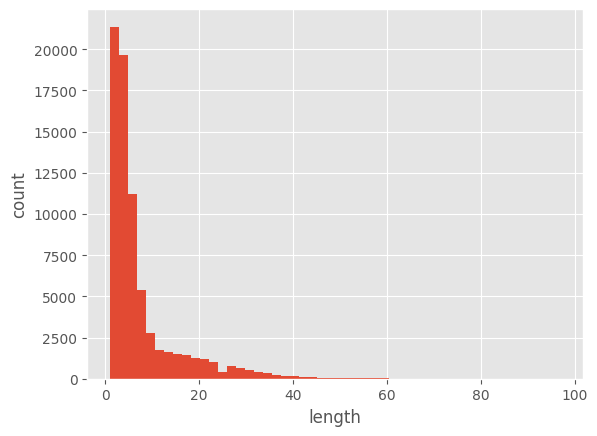

In [107]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length')
plt.ylabel('count')
plt.show()

# 0 ~ 20 정도의 길이가 대부분

**토크나이저로 정수 인코딩**
- oov = out of vocabulary
- 훈련 데이터에 등장하지 않았던 단어가 나오면 숫자 1을 부여해줌

In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentence_tokenizer = Tokenizer(oov_token='OOV')
tag_tokenizer = Tokenizer(lower=False)  # 대문자 유지

sentence_tokenizer.fit_on_texts(sentences)
tag_tokenizer.fit_on_texts(tags)

In [109]:
# 단어 인덱스가 1부터 시작, 0은 패딩에 사용하기 때문에 길이를 1 추가해서 본다.
vocab_size = len(sentence_tokenizer.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
print('단어 사전 크기 :', vocab_size)
print('개체명 사전 크기 :', tag_size)

단어 사전 크기 : 163424
개체명 사전 크기 : 31


In [110]:
print('OOV 인덱스 :', sentence_tokenizer.word_index['OOV'])

OOV 인덱스 : 1


In [111]:
# 정수 인코딩
X = sentence_tokenizer.texts_to_sequences(sentences)
y = tag_tokenizer.texts_to_sequences(tags)

In [112]:
print(X[1])
print(y[1])

[26533, 18573, 8457, 49, 7369, 325, 378, 223, 1184, 799, 692, 18574, 26534, 2945, 2636, 38]
[6, 7, 1, 2, 1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 1]


In [113]:
# 디코딩 확인
index_to_word = sentence_tokenizer.index_word
index_to_tag = tag_tokenizer.index_word

decoded = []

for i in X[1]:
    decoded.append(index_to_word[i])

print(sentences[1])
print(decoded)

['태안군의회', '김기두', '의장이', '지난해', '거둔', '성과를', '바탕으로', '올', '한해', '군민', '중심의', '의정활동을', '펼치겠다는', '힘찬', '포부를', '밝혔다.']
['태안군의회', '김기두', '의장이', '지난해', '거둔', '성과를', '바탕으로', '올', '한해', '군민', '중심의', '의정활동을', '펼치겠다는', '힘찬', '포부를', '밝혔다.']


**문장 길이를 맞추는 패딩 작업**
- 위 그래프에서 길이 70이내에 대부분의 데이터가 있어 길이를 70으로 맞춘다.

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 70

X_train = pad_sequences(X, padding='post', maxlen=max_len)
y_train = pad_sequences(y, padding='post', maxlen=max_len)

In [115]:
print(X_train[1])
print(y_train[1])

[26533 18573  8457    49  7369   325   378   223  1184   799   692 18574
 26534  2945  2636    38     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]
[6 7 1 2 1 1 1 2 8 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


**훈련 데이터셋과 테스트 데이터셋 분리**

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=2024)

In [117]:
y_train[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

**목표 변수 원-핫 인코딩**

In [118]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [119]:
y_train[1]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [120]:
print('훈련 샘플 크기', X_train.shape, y_train.shape)
print('검증 샘플 크기', X_test.shape, y_test.shape)

훈련 샘플 크기 (59503, 70) (59503, 70, 31)
검증 샘플 크기 (14876, 70) (14876, 70, 31)


**모델 구축, 학습**

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

model = Sequential()
# 임베딩 벡터 차원 128, 숫자 0은 연산에서 제외 (패딩으로 만들어진 0)
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
# 양방향 LSTM
model.add(Bidirectional(LSTM(64, return_sequences=True)))
# LSTM을 다 대 다 구조로 사용, 다중 분류이기 때문에 활성화 함수는 소프트맥스 함수 사용
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
1860/1860 [==============================] - 46s 23ms/step - loss: 0.0517 - accuracy: 0.9136 - val_loss: 0.0333 - val_accuracy: 0.9293
Epoch 2/8
1860/1860 [==============================] - 43s 23ms/step - loss: 0.0214 - accuracy: 0.9473 - val_loss: 0.0242 - val_accuracy: 0.9543
Epoch 3/8
1860/1860 [==============================] - 44s 23ms/step - loss: 0.0094 - accuracy: 0.9756 - val_loss: 0.0240 - val_accuracy: 0.9568
Epoch 4/8
1860/1860 [==============================] - 43s 23ms/step - loss: 0.0037 - accuracy: 0.9905 - val_loss: 0.0266 - val_accuracy: 0.9535
Epoch 5/8
1860/1860 [==============================] - 44s 24ms/step - loss: 0.0016 - accuracy: 0.9958 - val_loss: 0.0289 - val_accuracy: 0.9592
Epoch 6/8
1860/1860 [==============================] - 43s 23ms/step - loss: 7.7093e-04 - accuracy: 0.9980 - val_loss: 0.0312 - val_accuracy: 0.9579
Epoch 7/8
1860/1860 [==============================] - 43s 23ms/step - loss: 4.5130e-04 - accuracy: 0.9989 - val_loss: 0.0331 

**실제값과 예측값 비교**

In [131]:
import numpy as np

y_predicted = model.predict(np.array([X_test[2024]]))
y_predicted = np.argmax(y_predicted, axis=-1)
labels = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")
for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_tag[tag], index_to_tag[pred]))

1/1 [==============================] - 0s 19ms/step
단어             |실제값  |예측값
-----------------------------------
정말                  : O       O
아름다운                : O       O
곳이예요                : O       O
